# Measure WL Profiles

## Note

All functions in this section can be used passing the explicit arguments but are also internal functions of the cluster object, and should be used as such. They are just explicitely used here for clarity.

Ex:

```
theta, g_t, g_x = compute_tangential_and_cross_components(ra_lens, dec_lens,
                ra_source, dec_source, shear1, shear2)
```

should be done by the user as:

```
theta, g_t, g_x = cl.compute_tangential_and_cross_components()
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock

Make sure we know which version we're using

In [2]:
clmm.__version__

'1.12.0'

Define random seed for reproducibility

In [3]:
np.random.seed(11)

### Define cosmology object

In [4]:
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

## 1. Generate cluster object from mock data
In this example, the mock data includes: shape noise, galaxies drawn from redshift distribution and photoz errors.

Define toy cluster parameters for mock data generation. Notice that here we set the coordinate system for the ellipticity components as 'euclidean'. See https://doi.org/10.48550/arXiv.1407.7676 section 5.1 for more details.

In [5]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.0e15
cluster_z = 0.3
concentration = 4
ngals = 10000

cluster_ra = 0.0
cluster_dec = 90.0

zsrc_min = cluster_z + 0.1  # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    concentration,
    cosmo,
    "chang13",
    zsrc_min=zsrc_min,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngals=ngals,
    cluster_ra=cluster_ra,
    cluster_dec=cluster_dec,
    coordinate_system="euclidean",
)

Loading this into a CLMM cluster object centered on (0,0)

In [6]:
cl = GalaxyCluster(
    cluster_id, cluster_ra, cluster_dec, cluster_z, noisy_data_z, coordinate_system="euclidean"
)

### 2. Load cluster object containing:
> Lens properties (ra_l, dec_l, z_l)

> Source properties (ra_s, dec_s, e1, e2)
### Note, if loading from mock data, use: 
> cl = gc.GalaxyCluster.load("GC_from_mock_data.pkl")

In [7]:
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec, "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 90.0 ; z_l : 0.3
The number of source galaxies is : 10000


## 2. Basic checks and plots 
- galaxy positions
- redshift distribution

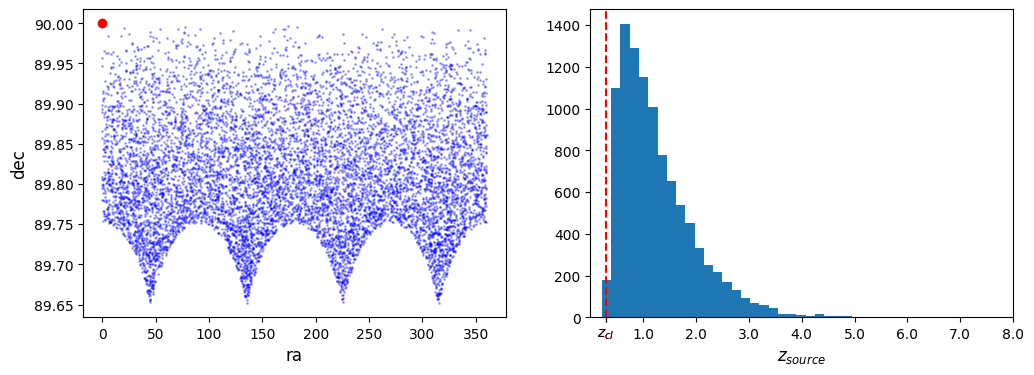

In [8]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(cl.galcat["ra"], cl.galcat["dec"], color="blue", s=1, alpha=0.3)
ax[0].plot(cl.ra, cl.dec, "ro")
ax[0].set_ylabel("dec", fontsize="large")
ax[0].set_xlabel("ra", fontsize="large")

hist = ax[1].hist(cl.galcat["z"], bins=40)[0]
ax[1].axvline(cl.z, c="r", ls="--")
ax[1].set_xlabel("$z_{source}$", fontsize="large")
xt = {t: f"{t}" for t in ax[1].get_xticks() if t != 0}
xt[cl.z] = "$z_{cl}$"
xto = sorted(list(xt.keys()) + [cl.z])
ax[1].set_xticks(xto)
ax[1].set_xticklabels(xt[t] for t in xto)
ax[1].get_xticklabels()[xto.index(cl.z)].set_color("red")
plt.xlim(0, max(xto))
plt.show()

- Check ellipticities

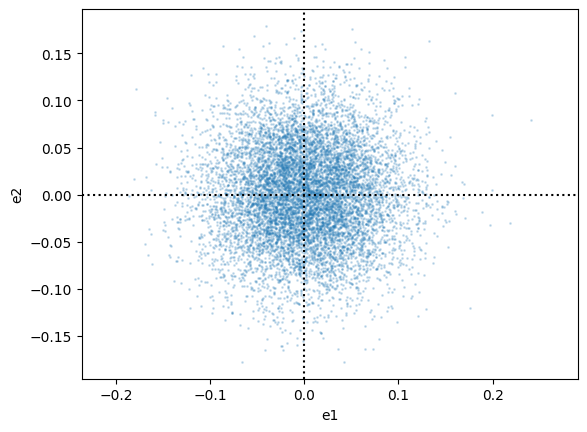

In [9]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(cl.galcat["e1"], cl.galcat["e2"], s=1, alpha=0.2)
ax1.set_xlabel("e1")
ax1.set_ylabel("e2")
ax1.set_aspect("equal", "datalim")
ax1.axvline(0, linestyle="dotted", color="black")
ax1.axhline(0, linestyle="dotted", color="black")

## 3. Compute and plot shear profiles

### 3.1 Compute angular separation, cross and tangential shear for each source galaxy

To keep things consistent, you also need to set the coordinate system to the same option.

In [10]:
theta, e_t, e_x = compute_tangential_and_cross_components(
    ra_lens=cl.ra,
    dec_lens=cl.dec,
    ra_source=cl.galcat["ra"],
    dec_source=cl.galcat["dec"],
    shear1=cl.galcat["e1"],
    shear2=cl.galcat["e2"],
    coordinate_system="euclidean",
)

#### 3.1.1 Using `GalaxyCluster` object
- You can also call the function directly from the `GalaxyCluster` object
- By defaut, `compute_tangential_and_cross_components` uses columns named `e1` and `e2` of the `galcat` table

In [11]:
cl.compute_tangential_and_cross_components(add=True)
# With the option add the cl object has theta, et and ex new columns
# (default: takes in columns named 'e1' and 'e2' and save the results in 'et' and 'ex')
cl.galcat["et", "ex"].pprint(max_width=-1)

          et                    ex          
--------------------- ----------------------
-0.014193669604212844   0.024770292812117598
 0.027593288682813785  -0.031444795110656676
-0.005206908899369735  -0.030510857504521028
  0.11232631436380155    0.07290036434929753
  -0.1256142518002091   0.018802231820255564
  0.01905520420174165    0.06050406041741734
 0.038412781291329155     0.0267416481414113
                  ...                    ...
 -0.03498815031434638 -0.0015608398752305023
  0.03187266724532613    -0.0733501029367589
  0.06922795072503296   -0.03909067857437158
 0.026474999081928356    0.04501156446867458
  0.06794774688091935    -0.0870781268087891
  0.11658596390772841  -0.007006942480985601
 -0.05827836241792691   -0.01879387705087386
  0.06611775764202141   -0.01725669970366957
Length = 10000 rows


- But it's also possible to choose which columns to use for input and output, e.g. Below we're storing the results in `e_tan` and `e_cross` instead (explicitely taking `e1` and `e2` as input)


In [12]:
cl.compute_tangential_and_cross_components(
    shape_component1="e1",
    shape_component2="e2",
    tan_component="e_tan",
    cross_component="e_cross",
    add=True,
)
cl.galcat["e_tan", "e_cross"].pprint(max_width=-1)

        e_tan                e_cross        
--------------------- ----------------------
-0.014193669604212844   0.024770292812117598
 0.027593288682813785  -0.031444795110656676
-0.005206908899369735  -0.030510857504521028
  0.11232631436380155    0.07290036434929753
  -0.1256142518002091   0.018802231820255564
  0.01905520420174165    0.06050406041741734
 0.038412781291329155     0.0267416481414113
                  ...                    ...
 -0.03498815031434638 -0.0015608398752305023
  0.03187266724532613    -0.0733501029367589
  0.06922795072503296   -0.03909067857437158
 0.026474999081928356    0.04501156446867458
  0.06794774688091935    -0.0870781268087891
  0.11658596390772841  -0.007006942480985601
 -0.05827836241792691   -0.01879387705087386
  0.06611775764202141   -0.01725669970366957
Length = 10000 rows


Plot tangential and cross ellipticity distributions for verification, which can be accessed in the galaxy cluster object, cl.

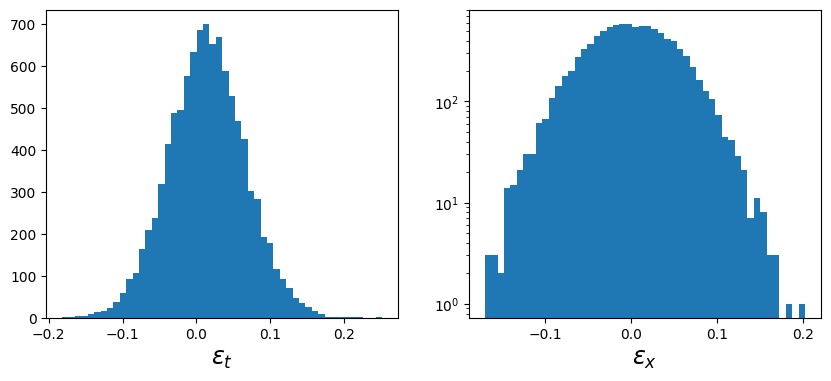

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(cl.galcat["et"], bins=50)
ax[0].set_xlabel("$\\epsilon_t$", fontsize="xx-large")

ax[1].hist(cl.galcat["ex"], bins=50)
ax[1].set_xlabel("$\\epsilon_x$", fontsize="xx-large")
ax[1].set_yscale("log")

Compute transversal and cross shear profiles in units defined by user, using defaults binning 

### 3.2 Compute shear profile in radial bins
Given the separations in "radians" computed in the previous step, the user may ask for a binned profile in various projected distance units.
#### 3.2.1 Default binning
- default binning using kpc:

In [14]:
profiles = make_radial_profile(
    [cl.galcat["et"], cl.galcat["ex"], cl.galcat["z"]],
    angsep=cl.galcat["theta"],
    angsep_units="radians",
    bin_units="kpc",
    cosmo=cosmo,
    z_lens=cl.z,
)
# profiles.pprint(max_width=-1)
profiles.show_in_notebook()

idx,radius_min,radius,radius_max,p_0,p_0_err,p_1,p_1_err,p_2,p_2_err,n_src,weights_sum
0,49.89926186693261,400.9726230193441,607.3017710391922,0.07369228018322337,0.004447742307624311,0.006080026121867752,0.0036037287135259077,1.2297028108389076,0.05112732075408661,166,166.0
1,607.3017710391922,923.2018463924193,1164.7042802114518,0.036146516837834985,0.00227935785688623,0.0018176846014553074,0.002206990305431071,1.2298067436515772,0.030682646493702392,489,489.0
2,1164.7042802114518,1456.2559152600973,1722.1067893837112,0.026008718990420572,0.0018649252714886548,-0.0021117832844851922,0.0017201795943530447,1.2904975456410464,0.025796286531234478,796,796.0
3,1722.1067893837112,2010.6275047741083,2279.509298555971,0.016452486829944015,0.0014934697870730717,-0.0012393150423236192,0.0015266379256973623,1.2405106399736192,0.021870519290172113,1104,1104.0
4,2279.509298555971,2566.574472794591,2836.9118077282305,0.01532508832599336,0.001347574981311564,0.0024568464199461472,0.001305269614002815,1.249718872885107,0.01937972914536564,1364,1364.0
5,2836.9118077282305,3126.401707455199,3394.3143169004898,0.010970572729309918,0.0012016555444631944,0.0017746612850044366,0.0011924727814665885,1.2654482714997306,0.017411676235896328,1752,1752.0
6,3394.3143169004898,3680.361810684455,3951.7168260727494,0.008230849462521983,0.001156373463097785,0.00026482017882748383,0.0011144802873654758,1.251906311652915,0.015901612106466533,1972,1972.0
7,3951.7168260727494,4206.44725604225,4509.119335245009,0.008368823939991624,0.0013187944446566538,0.0020117004045590563,0.001347544793784184,1.2339023632491457,0.018265497762874002,1447,1447.0
8,4509.119335245009,4740.680183376662,5066.521844417269,0.004837485395708415,0.001912862842344602,0.0026882532672738166,0.0018925728707443127,1.2803793398548848,0.027250788734393197,674,674.0
9,5066.521844417269,5263.692943534783,5623.924353589528,0.005696398425432693,0.0032082710618656033,-0.00011806820317390748,0.0031087370020959184,1.2520857801069578,0.044175488101642846,236,236.0


Note that, because this function bins a generic number of quantities in the radial profile, its output table names the quantities as `p_i` and errors as `p_i_err`.

#### 3.1.2 Using `GalaxyCluster` object
The output `GCData` corresponding to the binning profiled is attached as a new attribute of the galaxy cluster object.

In [15]:
cl.make_radial_profile("kpc", cosmo=cosmo)
# cl.profile.pprint(max_width=-1)
cl.profile.show_in_notebook()

idx,radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src,W_l
0,49.89926186693261,400.9726230193441,607.3017710391922,0.07369228018322337,0.004447742307624311,0.006080026121867752,0.0036037287135259077,1.2297028108389076,0.05112732075408661,166,166.0
1,607.3017710391922,923.2018463924193,1164.7042802114518,0.036146516837834985,0.00227935785688623,0.0018176846014553074,0.002206990305431071,1.2298067436515772,0.030682646493702392,489,489.0
2,1164.7042802114518,1456.2559152600973,1722.1067893837112,0.026008718990420572,0.0018649252714886548,-0.0021117832844851922,0.0017201795943530447,1.2904975456410464,0.025796286531234478,796,796.0
3,1722.1067893837112,2010.6275047741083,2279.509298555971,0.016452486829944015,0.0014934697870730717,-0.0012393150423236192,0.0015266379256973623,1.2405106399736192,0.021870519290172113,1104,1104.0
4,2279.509298555971,2566.574472794591,2836.9118077282305,0.01532508832599336,0.001347574981311564,0.0024568464199461472,0.001305269614002815,1.249718872885107,0.01937972914536564,1364,1364.0
5,2836.9118077282305,3126.401707455199,3394.3143169004898,0.010970572729309918,0.0012016555444631944,0.0017746612850044366,0.0011924727814665885,1.2654482714997306,0.017411676235896328,1752,1752.0
6,3394.3143169004898,3680.361810684455,3951.7168260727494,0.008230849462521983,0.001156373463097785,0.00026482017882748383,0.0011144802873654758,1.251906311652915,0.015901612106466533,1972,1972.0
7,3951.7168260727494,4206.44725604225,4509.119335245009,0.008368823939991624,0.0013187944446566538,0.0020117004045590563,0.001347544793784184,1.2339023632491457,0.018265497762874002,1447,1447.0
8,4509.119335245009,4740.680183376662,5066.521844417269,0.004837485395708415,0.001912862842344602,0.0026882532672738166,0.0018925728707443127,1.2803793398548848,0.027250788734393197,674,674.0
9,5066.521844417269,5263.692943534783,5623.924353589528,0.005696398425432693,0.0032082710618656033,-0.00011806820317390748,0.0031087370020959184,1.2520857801069578,0.044175488101642846,236,236.0


You can see that this `profile` table contains metadata regarding the comology and bin units

In [16]:
print("Cosmology:", cl.profile.meta["cosmo"])
print("bin units:", cl.profile.meta["bin_units"])

Cosmology: CCLCosmology(H0=70.0, Omega_dm0=0.22500000000000003, Omega_b0=0.045, Omega_k0=0.0)
bin units: kpc


Use function to plot the profiles

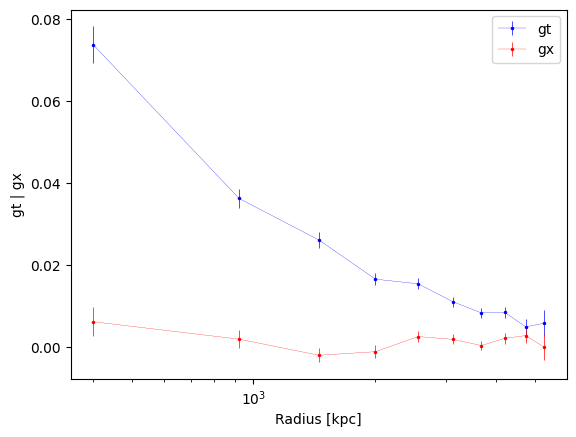

In [17]:
fig, ax = cl.plot_profiles(xscale="log")

- default binning using degrees:

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/galaxycluster.py:613: UserWarning: overwriting profile table.


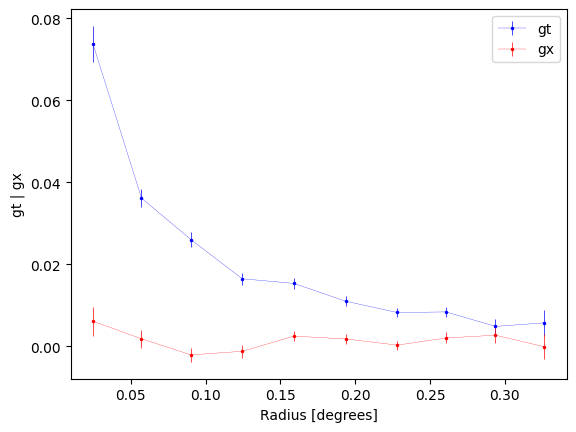

In [18]:
new_profiles = cl.make_radial_profile("degrees", cosmo=cosmo)
fig1, ax1 = cl.plot_profiles()

#### 3.2.2 User-defined binning 
The users may also provide their own binning, in user-defined units, to compute the transversal and cross shear profiles. The `make_bins` function is provided in `utils.py` and allow for various options. 

- e.g., generate 20 bins between 1 and 6 Mpc, linearly spaced.

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/galaxycluster.py:613: UserWarning: overwriting profile table.


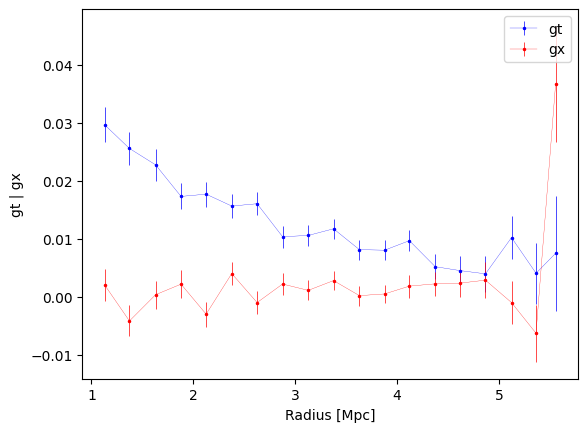

In [19]:
new_bins = make_bins(1, 6, nbins=20, method="evenwidth")

# Make the shear profile in this binning
new_profiles = cl.make_radial_profile("Mpc", bins=new_bins, cosmo=cosmo)

fig1, ax1 = cl.plot_profiles()

- e.g., generate 20 bins between 1 and 6 Mpc, evenly spaced in log space.

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/galaxycluster.py:613: UserWarning: overwriting profile table.


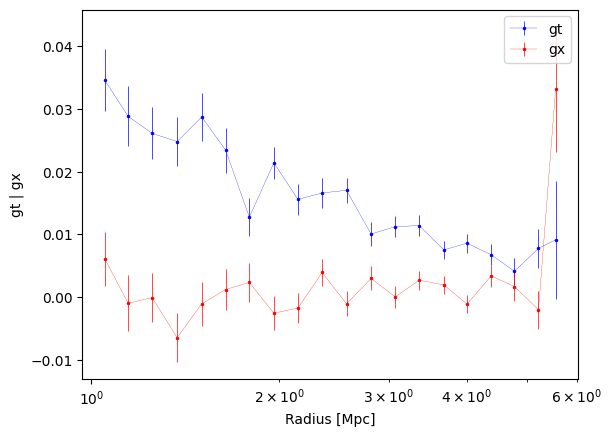

In [20]:
new_bins = make_bins(1, 6, nbins=20, method="evenlog10width")

new_profiles = cl.make_radial_profile("Mpc", bins=new_bins, cosmo=cosmo)
fig1, ax1 = cl.plot_profiles()
ax1.set_xscale("log")

 e.g., generate 20 bins between 1 and 6 Mpc, each contaning the same number of galaxies

number of galaxies in each bin: [477, 477, 476, 477, 476, 477, 476, 477, 476, 477, 477, 476, 477, 476, 477, 476, 477, 476, 477, 477]


/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/galaxycluster.py:613: UserWarning: overwriting profile table.


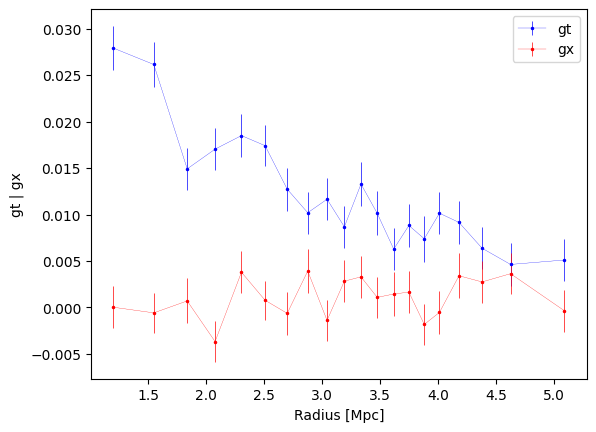

In [21]:
# First, convert the source separation table to Mpc
seps = u.convert_units(cl.galcat["theta"], "radians", "Mpc", redshift=cl.z, cosmo=cosmo)

new_bins = make_bins(1, 6, nbins=20, method="equaloccupation", source_seps=seps)
new_profiles = cl.make_radial_profile("Mpc", bins=new_bins, cosmo=cosmo)

print(f"number of galaxies in each bin: {list(cl.profile['n_src'])}")
fig1, ax1 = cl.plot_profiles()

#### 3.2.3 Other individual profile quantities may also be accessed 

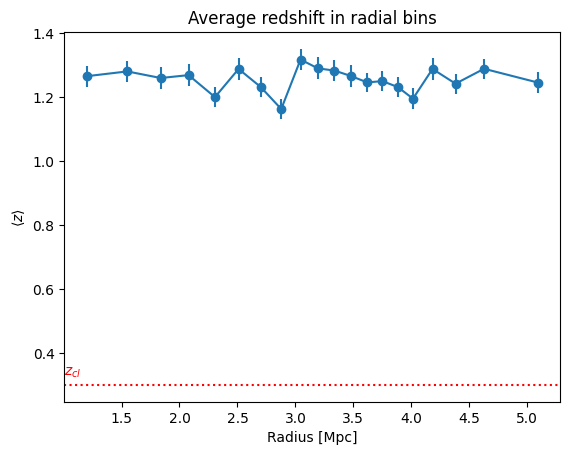

In [22]:
plt.title("Average redshift in radial bins")
plt.errorbar(new_profiles["radius"], new_profiles["z"], new_profiles["z_err"], marker="o")
plt.axhline(cl.z, linestyle="dotted", color="r")
plt.text(1, cl.z * 1.1, "$z_{cl}$", color="r")
plt.xlabel("Radius [Mpc]")
plt.ylabel("$\langle z\\rangle$")
plt.show()

## 4. Focus on some options
### 4.1. `gal_ids_in_bins` option 
adds a `gal_id` field to the profile GCData. For each bin of the profile, this is filled with the list of galaxy IDs for the galaxies that have fallen in that bin.

In [23]:
cl.make_radial_profile("Mpc", cosmo=cosmo, gal_ids_in_bins=True)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/galaxycluster.py:613: UserWarning: overwriting profile table.


In [24]:
# Here the list of galaxy IDs that are in the first bin of the tangential shear profile
gal_list = cl.profile["gal_id"][0]
print(gal_list)

[30, 132, 180, 184, 190, 268, 346, 369, 433, 542, 553, 791, 822, 988, 1023, 1105, 1113, 1198, 1199, 1205, 1212, 1240, 1281, 1308, 1357, 1607, 1648, 1672, 1741, 1754, 1846, 1907, 1957, 2006, 2014, 2338, 2561, 2618, 2622, 2632, 2719, 2833, 2841, 2856, 2964, 3052, 3062, 3087, 3088, 3096, 3116, 3188, 3324, 3400, 3433, 3551, 3572, 3691, 3694, 3746, 3790, 3849, 3855, 3862, 3878, 3893, 4033, 4037, 4048, 4215, 4236, 4300, 4321, 4344, 4496, 4559, 4562, 4651, 4746, 4889, 4942, 4956, 5073, 5139, 5268, 5294, 5345, 5391, 5608, 5785, 5900, 5925, 5961, 5993, 6025, 6153, 6179, 6218, 6284, 6318, 6322, 6349, 6431, 6610, 6636, 6651, 6701, 6706, 6786, 6802, 6818, 6859, 6963, 6970, 7017, 7079, 7212, 7330, 7376, 7383, 7402, 7415, 7448, 7462, 7489, 7723, 7793, 7870, 7933, 7949, 8023, 8073, 8122, 8137, 8211, 8399, 8501, 8527, 8566, 8653, 8822, 8873, 8879, 8915, 8922, 8937, 9128, 9130, 9138, 9188, 9189, 9252, 9470, 9519, 9589, 9596, 9712, 9749, 9775, 9785, 9804, 9867, 9870, 9943, 9990, 9997]


### 4.2. User-defined naming scheme
The user may specify which columns to use from the `galcat` table to perform the binned average. If none is specified, the code looks for columns names `et` and `ex`. Below, we average in bins the columns`e_tan` and `e_cross` of `galcat` and store the results in the columns `g_tan` and `g_cross` of the `profile` table of the cluster object.

In [25]:
cl.make_radial_profile(
    "kpc",
    cosmo=cosmo,
    tan_component_in="e_tan",
    cross_component_in="e_cross",
    tan_component_out="g_tan",
    cross_component_out="g_cross",
)
# cl.profile.pprint(max_width=-1)
cl.profile.show_in_notebook()

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/galaxycluster.py:613: UserWarning: overwriting profile table.


idx,radius_min,radius,radius_max,g_tan,g_tan_err,g_cross,g_cross_err,z,z_err,n_src,W_l
0,49.89926186693261,400.9726230193441,607.3017710391922,0.07369228018322337,0.004447742307624311,0.006080026121867752,0.0036037287135259077,1.2297028108389076,0.05112732075408661,166,166.0
1,607.3017710391922,923.2018463924193,1164.7042802114518,0.036146516837834985,0.00227935785688623,0.0018176846014553074,0.002206990305431071,1.2298067436515772,0.030682646493702392,489,489.0
2,1164.7042802114518,1456.2559152600973,1722.1067893837112,0.026008718990420572,0.0018649252714886548,-0.0021117832844851922,0.0017201795943530447,1.2904975456410464,0.025796286531234478,796,796.0
3,1722.1067893837112,2010.6275047741083,2279.509298555971,0.016452486829944015,0.0014934697870730717,-0.0012393150423236192,0.0015266379256973623,1.2405106399736192,0.021870519290172113,1104,1104.0
4,2279.509298555971,2566.574472794591,2836.9118077282305,0.01532508832599336,0.001347574981311564,0.0024568464199461472,0.001305269614002815,1.249718872885107,0.01937972914536564,1364,1364.0
5,2836.9118077282305,3126.401707455199,3394.3143169004898,0.010970572729309918,0.0012016555444631944,0.0017746612850044366,0.0011924727814665885,1.2654482714997306,0.017411676235896328,1752,1752.0
6,3394.3143169004898,3680.361810684455,3951.7168260727494,0.008230849462521983,0.001156373463097785,0.00026482017882748383,0.0011144802873654758,1.251906311652915,0.015901612106466533,1972,1972.0
7,3951.7168260727494,4206.44725604225,4509.119335245009,0.008368823939991624,0.0013187944446566538,0.0020117004045590563,0.001347544793784184,1.2339023632491457,0.018265497762874002,1447,1447.0
8,4509.119335245009,4740.680183376662,5066.521844417269,0.004837485395708415,0.001912862842344602,0.0026882532672738166,0.0018925728707443127,1.2803793398548848,0.027250788734393197,674,674.0
9,5066.521844417269,5263.692943534783,5623.924353589528,0.005696398425432693,0.0032082710618656033,-0.00011806820317390748,0.0031087370020959184,1.2520857801069578,0.044175488101642846,236,236.0


The user may also define the name of the output table attribute. Below, we asked the binned profile to be saved into the `reduced_shear_profile` attribute

In [26]:
cl.make_radial_profile(
    "kpc",
    cosmo=cosmo,
    tan_component_in="e_tan",
    cross_component_in="e_cross",
    tan_component_out="g_tan",
    cross_component_out="g_cross",
    table_name="reduced_shear_profile",
)
# cl.reduced_shear_profile.pprint(max_width=-1)
cl.reduced_shear_profile.show_in_notebook()

idx,radius_min,radius,radius_max,g_tan,g_tan_err,g_cross,g_cross_err,z,z_err,n_src,W_l
0,49.89926186693261,400.9726230193441,607.3017710391922,0.07369228018322337,0.004447742307624311,0.006080026121867752,0.0036037287135259077,1.2297028108389076,0.05112732075408661,166,166.0
1,607.3017710391922,923.2018463924193,1164.7042802114518,0.036146516837834985,0.00227935785688623,0.0018176846014553074,0.002206990305431071,1.2298067436515772,0.030682646493702392,489,489.0
2,1164.7042802114518,1456.2559152600973,1722.1067893837112,0.026008718990420572,0.0018649252714886548,-0.0021117832844851922,0.0017201795943530447,1.2904975456410464,0.025796286531234478,796,796.0
3,1722.1067893837112,2010.6275047741083,2279.509298555971,0.016452486829944015,0.0014934697870730717,-0.0012393150423236192,0.0015266379256973623,1.2405106399736192,0.021870519290172113,1104,1104.0
4,2279.509298555971,2566.574472794591,2836.9118077282305,0.01532508832599336,0.001347574981311564,0.0024568464199461472,0.001305269614002815,1.249718872885107,0.01937972914536564,1364,1364.0
5,2836.9118077282305,3126.401707455199,3394.3143169004898,0.010970572729309918,0.0012016555444631944,0.0017746612850044366,0.0011924727814665885,1.2654482714997306,0.017411676235896328,1752,1752.0
6,3394.3143169004898,3680.361810684455,3951.7168260727494,0.008230849462521983,0.001156373463097785,0.00026482017882748383,0.0011144802873654758,1.251906311652915,0.015901612106466533,1972,1972.0
7,3951.7168260727494,4206.44725604225,4509.119335245009,0.008368823939991624,0.0013187944446566538,0.0020117004045590563,0.001347544793784184,1.2339023632491457,0.018265497762874002,1447,1447.0
8,4509.119335245009,4740.680183376662,5066.521844417269,0.004837485395708415,0.001912862842344602,0.0026882532672738166,0.0018925728707443127,1.2803793398548848,0.027250788734393197,674,674.0
9,5066.521844417269,5263.692943534783,5623.924353589528,0.005696398425432693,0.0032082710618656033,-0.00011806820317390748,0.0031087370020959184,1.2520857801069578,0.044175488101642846,236,236.0


### 4.3 Compute a DeltaSigma profile instead of a shear profile

The `is_deltasigma` option allows the user to return a cross and tangential $\Delta\Sigma$ (excess surface density) value for each galaxy in the catalog, provided `galcat` contains the redshifts of the galaxies and provided a cosmology is passed to the function. The columns `DeltaSigma_tan` and `DeltaSigma_cross` are added to the `galcat` table.

In [27]:
cl.compute_tangential_and_cross_components(
    shape_component1="e1",
    shape_component2="e2",
    tan_component="DeltaSigma_tan",
    cross_component="DeltaSigma_cross",
    add=True,
    cosmo=cosmo,
    is_deltasigma=True,
)
cl.galcat.columns

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/cosmology/parent_class.py:110: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


<TableColumns names=('ra','dec','e1','e2','z','ztrue','pzpdf','id','theta','et','ex','e_tan','e_cross','sigma_c','DeltaSigma_tan','DeltaSigma_cross')>

The signal-to-noise of a $\Delta\Sigma$ profile is improved when applying optimal weights accounting for photoz, shape noise, precision of the shape measurements. These weights are computed using the `compute_galaxy_weights` methods of the `GalaxyCluster` class, ans stored as an extra columns of the `galcat` table (see the `demo_compute_deltasigma_weights` notebook).


In [28]:
cl.compute_galaxy_weights(
    use_pdz=True,
    use_shape_noise=True,
    shape_component1="e1",
    shape_component2="e2",
    cosmo=cosmo,
    is_deltasigma=True,
    add=True,
)

cl.galcat.columns

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/cosmology/parent_class.py:110: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/redshift/tools.py:58: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


<TableColumns names=('ra','dec','e1','e2','z','ztrue','pzpdf','id','theta','et','ex','e_tan','e_cross','sigma_c','DeltaSigma_tan','DeltaSigma_cross','sigma_c_eff','w_ls')>

Because these operations required a `Cosmology`, it was added to `galcat` metadata:

In [29]:
cl.galcat.meta["cosmo"]

'CCLCosmology(H0=70.0, Omega_dm0=0.22500000000000003, Omega_b0=0.045, Omega_k0=0.0)'

The binned profile is obtained, as before. Below, we use the values obtained from the previous step to compute the binned profile. The latter is saved in a new `DeltaSigma_profile` table of the GalaxyCluster object. If `use_weights=True`, the weighted average is performed using the weights stored in `galcat`.

In [30]:
"""
cl.make_radial_profile("Mpc", cosmo=cosmo, 
                       tan_component_in='DeltaSigma_tan', cross_component_in='DeltaSigma_cross',
                       tan_component_out='DeltaSigma_tan', cross_component_out='DeltaSigma_cross',
                       table_name='DeltaSigma_profile').pprint(max_width=-1)
"""

cl.make_radial_profile(
    "Mpc",
    cosmo=cosmo,
    tan_component_in="DeltaSigma_tan",
    cross_component_in="DeltaSigma_cross",
    tan_component_out="DeltaSigma_tan",
    cross_component_out="DeltaSigma_cross",
    table_name="DeltaSigma_profile",
    use_weights=True,
)

In [31]:
# cl.DeltaSigma_profile.pprint(max_width=-1)
cl.DeltaSigma_profile.show_in_notebook()

idx,radius_min,radius,radius_max,DeltaSigma_tan,DeltaSigma_tan_err,DeltaSigma_cross,DeltaSigma_cross_err,z,z_err,n_src,W_l
0,0.04989926186693261,0.40181702725637763,0.6073017710391921,212624096345829.0,12655402657482.34,15732761567739.2,12296182303656.045,1.4635671916807829,0.05767766943930792,166,3.9434463355203155e-27
1,0.6073017710391921,0.9199782895807896,1.1647042802114518,107977347608942.4,7146281284443.758,7854532242277.548,6871295327248.185,1.4877929742814768,0.03349197273932527,489,1.1389768721844857e-26
2,1.1647042802114518,1.4541808661704045,1.722106789383711,74201758964831.69,10177508339578.314,-5945024572810.498,11944613981983.064,1.53634577671528,0.028559938092406277,796,1.9263161256553196e-26
3,1.722106789383711,2.009026398675808,2.2795092985559706,46230165382404.266,4653190892495.733,-3134990325918.1147,4649628199369.97,1.4970067826674796,0.024468325558512975,1104,2.5722490049731086e-26
4,2.2795092985559706,2.5659132611205,2.8369118077282303,43758379098921.61,4082127758886.9214,5693879230724.08,3946533113222.477,1.5110619977710171,0.021708960897932852,1364,3.20821505736507e-26
5,2.8369118077282303,3.1303364895961208,3.3943143169004895,30806708059922.492,3852954883455.5986,4681373494567.769,3834674599987.0,1.50328337268401,0.01851733775778793,1752,4.1690647252400884e-26
6,3.3943143169004895,3.67906429481997,3.951716826072749,23886688363580.285,3507193605501.203,-219434498994.54016,3416172893642.016,1.496410367969561,0.01749984171282461,1972,4.671278634008201e-26
7,3.951716826072749,4.208194447614443,4.509119335245009,22855624279366.883,4198818643913.0425,5320352842195.886,4188709345517.623,1.4969016764903829,0.02078608557490179,1447,3.3876100059854246e-26
8,4.509119335245009,4.73645792931896,5.066521844417268,12048101637529.803,5702911589032.317,9297096328274.342,5661409712336.724,1.5349261798982219,0.02918830507144148,674,1.6166131613764404e-26
9,5.066521844417268,5.265782408007534,5.623924353589528,17132048449502.818,9626411199780.168,-2710585711141.1577,9301892446424.824,1.490741829321991,0.047831337994038804,236,5.6205020593840896e-27


To compare, we make use of the functional interface to compute the unweighted averaged profile. The outputs columns are called by default `p_0`, `p_1`, etc.

In [32]:
avg_profile_noweights = make_radial_profile(
    [cl.galcat["DeltaSigma_tan"], cl.galcat["DeltaSigma_cross"]],
    cl.galcat["theta"],
    z_lens=cl.z,
    bin_units="Mpc",
    angsep_units="radians",
    cosmo=cosmo,
    weights=None,
)
avg_profile_noweights.columns

<TableColumns names=('radius_min','radius','radius_max','p_0','p_0_err','p_1','p_1_err','n_src','weights_sum')>

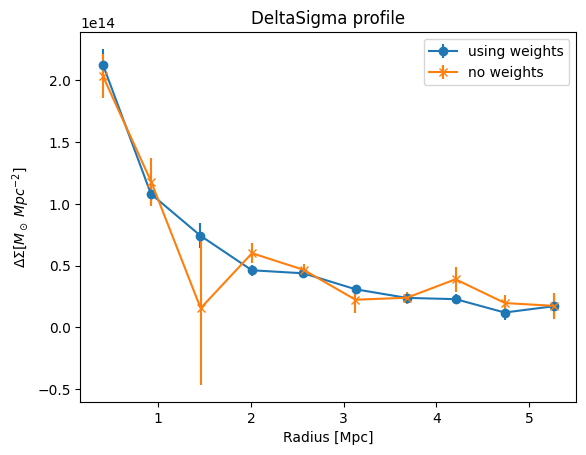

In [33]:
plt.errorbar(
    cl.DeltaSigma_profile["radius"],
    cl.DeltaSigma_profile["DeltaSigma_tan"],
    cl.DeltaSigma_profile["DeltaSigma_tan_err"],
    marker="o",
    label="using weights",
)
plt.errorbar(
    avg_profile_noweights["radius"],
    avg_profile_noweights["p_0"],
    avg_profile_noweights["p_0_err"],
    marker="x",
    label="no weights",
)

plt.title("DeltaSigma profile")
plt.xlabel("Radius [Mpc]")
plt.ylabel("$\Delta\Sigma [M_\odot\; Mpc^{-2}]$")
plt.legend()
plt.show()